In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Rosenblatt Perceptron** :

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels).

In [6]:
df = pd.read_csv('/content/toy_dataset.csv')

In [7]:
df.shape

(150000, 6)

In [9]:
df.head()

,Number,City,Gender,Age,Income,Illness
0,1,Dallas,Male,41,40367.0,No
1,2,Dallas,Male,54,45084.0,No
2,3,Dallas,Male,42,52483.0,No
3,4,Dallas,Male,40,40941.0,No
4,5,Dallas,Male,46,50289.0,No


In [11]:
X = df[['Age' , 'Income']].values
y = df['Illness'].map({'No': 0, 'Yes': 1}).values

In [12]:
print('Class label counts: ' , np.bincount(y))
print('X.shape:' , X.shape)
print('y.shape: ' , y.shape)

Class label counts:  [137861  12139]
X.shape: (150000, 2)
y.shape:  (150000,)


In [13]:
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X , y = X[shuffle_idx] , y[shuffle_idx]

In [14]:
X_train , X_test = X[:70000] , X[70000:]
y_train , y_test = y[:70000] , y[70000:]

In [15]:
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

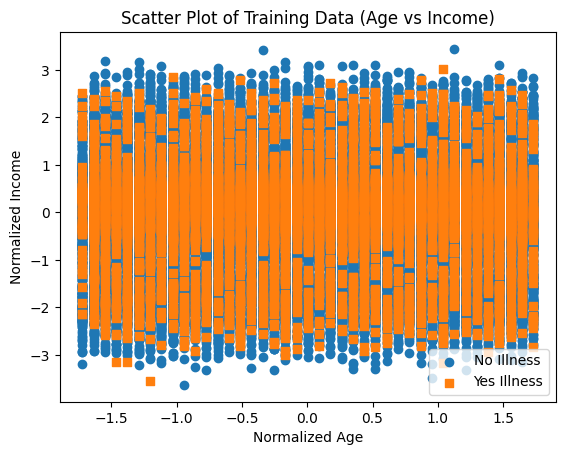

In [16]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='No Illness', marker='o')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Yes Illness', marker='s')

plt.xlabel('Normalized Age')
plt.ylabel('Normalized Income')
plt.legend()
plt.title('Scatter Plot of Training Data (Age vs Income)')
plt.show()

The Perceptron is a linear binary classifier introduced by Frank Rosenblatt in 1958. It's one of the earliest neural network models and forms the foundation of modern deep learning.



In [17]:
import torch

In [18]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
# Custom where for binary thresholding
def custom_where(cond, x_1, x_2):

    return torch.where(cond, x_1, x_2)

# Perceptron class
class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = custom_where(linear > 0., 1, 0).float()
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors

    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

# Training the Perceptron
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

In [21]:
print('Model parameters:')
print('  Weights:', ppn.weights)
print('  Bias:', ppn.bias)

# Evaluating the model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc * 100))


Model parameters:
  Weights: tensor([[-2.2522],
        [-0.0293]], device='cuda:0')
  Bias: tensor([-2.], device='cuda:0')
Test set accuracy: 71.64%


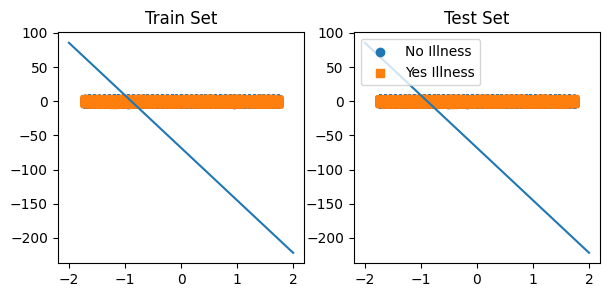

In [22]:
# Plotting the decision boundary
w, b = ppn.weights, ppn.bias

x_min = -2
x_max = 2
y_min = (-(w[0] * x_min) - b[0]) / w[1]
y_max = (-(w[0] * x_max) - b[0]) / w[1]

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min.item(), y_max.item()])
ax[1].plot([x_min, x_max], [y_min.item(), y_max.item()])

ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='No Illness', marker='o')
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Yes Illness', marker='s')

ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='No Illness', marker='o')
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='Yes Illness', marker='s')

ax[1].legend(loc='upper left')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()